# Preprocess
#### Takes raw numpy arrays, converts them to dataframes,  generates jet images, and normalizes variables

## Setup

In [1]:
import glob
import os
import time

import numpy as np
seed = 7
np.random.seed(seed)
import pandas as pd
from keras import backend as K

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from utils import profile_data

Using TensorFlow backend.


In [2]:
####################
# Global Variables #
####################
radius = 'ak5' # Jet radius to use. Either 'ak5' or 'ak7'
jet_pt_cut = 50

nx = 25 if radius == 'ak5' else 30 # size of image in eta
ny = 25 if radius == 'ak5' else 30 # size of image in phi
xbins = np.linspace(-1.0,1.0,nx+1)
ybins = np.linspace(-1.0,1.0,ny+1)

## Functions

In [3]:
def make_jet_images(df_jets, df_cands):
    njets = len(df_jets)
    x_coords, y_coords, w_values = [], [], []    
    jet_images=np.zeros((njets, nx, ny, 1)) # 4D tensor with indices: jet index, eta, phi, pt/rgb value

    for i in range(0, njets):
        
        if i%10000==0: print('\tProcessed {} events out of {}'.format(i, njets))

        # Get the pf cands of the ith jet by matching the jet to its pf cands
        df_cand_i = df_cands[(df_cands['pfcand_ijet'] == df_jets['pfcand_ijet'].iloc[i]) &
                             (df_cands['event'] == df_jets['event'].iloc[i]) &
                             (df_cands['jet_pt'] == df_jets['jet_pt'].iloc[i])]

        # Center jet on highest pt pf cand and convert (eta, phi) coordinates to (x, y)
        x = df_cand_i['pfcand_eta']-df_cand_i['pfcand_eta'].iloc[0]
        y = df_cand_i['pfcand_phi']-df_cand_i['pfcand_phi'].iloc[0]
        weights = df_cand_i['pfcand_pt'] # pt of candidate is the weight
        
        # Create a 2D histogram representing the jet image and then convert to an array
        hist, xedges, yedges = np.histogram2d(x.values, y.values, weights=weights, bins=(xbins,ybins))
        for ix in range(0,nx):
            for iy in range(0,ny):
                jet_images[i,ix,iy,0] = hist[ix,iy]
    
    return jet_images

In [4]:
def process_one(infile):
    start = time.clock()
    
    # Load file
    data = np.load(infile)
    
    # Create dataframes holding the jet-level information and pf candidate-level information
    df_jets = pd.DataFrame(data,columns=['run','lumi','event','met','sumet','rho','pthat','mcweight','njet','jet_pt','jet_eta','jet_phi','jet_E','jet_area','jet_jes','gen_pt','jet_gen_dr',
                                                  'chf','nhf','phf','elf','muf','hf_hf','hf_phf','hf_hm','hf_phm','chm','nhm','phm','elm','mum','beta','bstar','pfcand_ijet'])
    df_jets = df_jets.drop_duplicates()
    df_jets = df_jets[(df_jets.jet_pt > jet_pt_cut)]

    df_cands = pd.DataFrame(data, columns=['event', 'jet_pt', 'jet_eta', 'jet_phi','pfcand_pt', 'pfcand_eta', 'pfcand_phi', 'pfcand_id', 'pfcand_charge', 'pfcand_ijet'])
    df_cands = df_cands[(df_cands.jet_pt > jet_pt_cut)]
      
    # Add response to dataframe
    df_jets['jet_resp'] = df_jets['jet_pt']/df_jets['gen_pt']
        
    # Make jet images
    jet_images = make_jet_images(df_jets, df_cands)
    # Add jet images to dataframe
    df_jets['jet_images'] = [x for x in jet_images]

    end = time.clock()
    mins = (end-start)/60.
    
    print('\n\tFinished file in {:.2f} minutes ({:.2f} events/minute)\n'.format(mins, len(df_jets)/mins))
    return df_jets

## Processing

#### Process each file individually

In [5]:
first_file, last_file = 36, 38
files = ['/cms-sc17/deepjec/{}PFJetsParams0_{}.npy'.format(radius, x) for x in range(first_file, last_file+1)]

In [6]:
for i, infile in enumerate(files, first_file):    
    if i==8: continue; # Missing file 8
    print('File {} out of {}'.format(i, last_file))
    df = process_one(infile)
    # Save files as you go, so you don't always have to run over all files
    df.to_pickle('data/{}/df_jets_{}_{}.pkl'.format(radius, radius, i))

File 36 out of 38
	Processed 0 events out of 88218
	Processed 10000 events out of 88218
	Processed 20000 events out of 88218
	Processed 30000 events out of 88218
	Processed 40000 events out of 88218
	Processed 50000 events out of 88218
	Processed 60000 events out of 88218
	Processed 70000 events out of 88218
	Processed 80000 events out of 88218

	Finished file in 15.14 minutes (5828.29 events/minute)

File 37 out of 38
	Processed 0 events out of 71156
	Processed 10000 events out of 71156
	Processed 20000 events out of 71156
	Processed 30000 events out of 71156
	Processed 40000 events out of 71156
	Processed 50000 events out of 71156
	Processed 60000 events out of 71156
	Processed 70000 events out of 71156

	Finished file in 9.90 minutes (7187.11 events/minute)

File 38 out of 38
	Processed 0 events out of 76950
	Processed 10000 events out of 76950
	Processed 20000 events out of 76950
	Processed 30000 events out of 76950
	Processed 40000 events out of 76950
	Processed 50000 events out o

#### Concat all the files together

In [7]:
dfs = []
for i in range(first_file, last_file+1):
    if i==8: continue; # Missing file 8    
    dfs.append(pd.read_pickle('data/{}/df_jets_{}_{}.pkl'.format(radius, radius, i)))

df_all = pd.concat(dfs)

print('Dataframe shape:\n\t{}'.format(df_all.shape))
print('Dataframe columns:\n\t{}'.format(df_all.columns))

Dataframe shape:
	(236324, 36)
Dataframe columns:
	Index([u'run', u'lumi', u'event', u'met', u'sumet', u'rho', u'pthat',
       u'mcweight', u'njet', u'jet_pt', u'jet_eta', u'jet_phi', u'jet_E',
       u'jet_area', u'jet_jes', u'gen_pt', u'jet_gen_dr', u'chf', u'nhf',
       u'phf', u'elf', u'muf', u'hf_hf', u'hf_phf', u'hf_hm', u'hf_phm',
       u'chm', u'nhm', u'phm', u'elm', u'mum', u'beta', u'bstar',
       u'pfcand_ijet', u'jet_resp', u'jet_images'],
      dtype='object')


#### Remove all entries with gen_pt < 0 (where jet matching failed) 

In [8]:
df_all = df_all[df_all.gen_pt>=0]
print('Number of events = {}'.format(len(df_all)))

Number of events = 236323


## Plots

#### Check to make sure the variables look okay

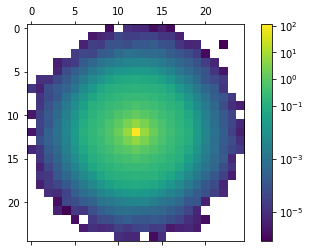

In [9]:
# Average jet image
avg_image = np.sum(df_all.jet_images)/len(df_all)

fig, ax = plt.subplots()
cax = ax.matshow(avg_image.reshape((nx, ny)), norm=mpl.colors.LogNorm())
cbar = fig.colorbar(cax, ticks=[0.0000001, 0.00001, 0.001, 0.1, 1, 10, 100])

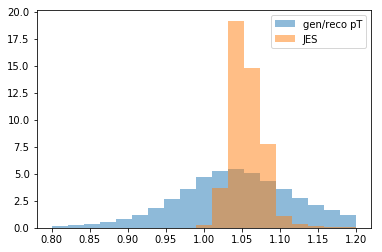

In [10]:
bins=np.linspace(0.8,1.2,20)
plt.figure()
plt.hist(df_all['gen_pt']/df_all['jet_pt'], label='gen/reco pT', alpha=0.5, bins=bins, normed=True)
plt.hist(df_all['jet_jes'], label='JES', alpha=0.5, bins=bins, normed=True)
plt.legend()
plt.show()

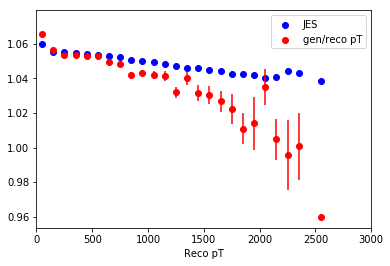

In [11]:
profile_data(df_all['jet_pt'], [df_all['jet_jes'], df_all['gen_pt']/df_all['jet_pt']], 30, 0, 3000, ['b','r'], plabels=['JES', 'gen/reco pT'], xlabel='Reco pT')

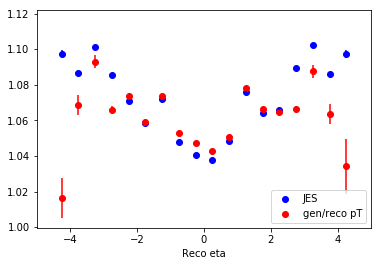

In [12]:
profile_data(df_all['jet_eta'], [df_all['jet_jes'], df_all['gen_pt']/df_all['jet_pt']], 20, -5.0, 5.0, ['b','r'], plabels=['JES', 'gen/reco pT'], xlabel='Reco eta')

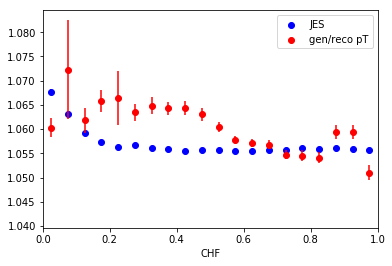

In [13]:
profile_data(df_all['chf'], [df_all['jet_jes'], df_all['gen_pt']/df_all['jet_pt']], 20, 0, 1, ['b','r'], plabels=['JES', 'gen/reco pT'], xlabel='CHF')

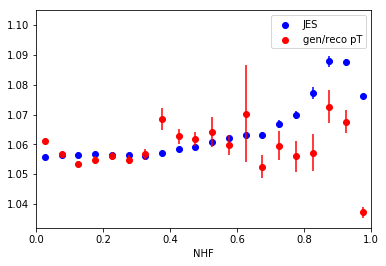

In [14]:
profile_data(df_all['nhf'], [df_all['jet_jes'], df_all['gen_pt']/df_all['jet_pt']], 20, 0, 1, ['b','r'], plabels=['JES', 'gen/reco pT'], xlabel='NHF')

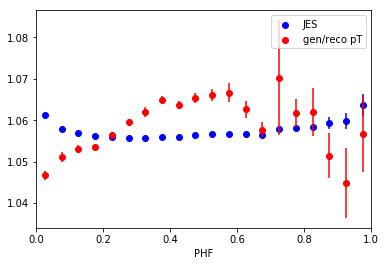

In [15]:
profile_data(df_all['phf'], [df_all['jet_jes'], df_all['gen_pt']/df_all['jet_pt']], 20, 0, 1, ['b','r'], plabels=['JES', 'gen/reco pT'], xlabel='PHF')

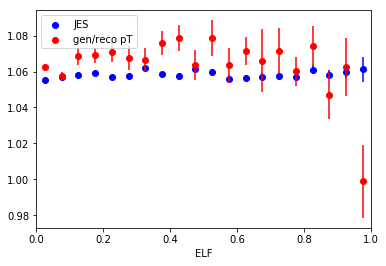

In [16]:
profile_data(df_all['elf'], [df_all['jet_jes'], df_all['gen_pt']/df_all['jet_pt']], 20, 0, 1, ['b','r'], plabels=['JES', 'gen/reco pT'], xlabel='ELF')

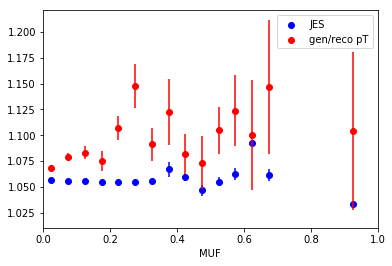

In [17]:
profile_data(df_all['muf'], [df_all['jet_jes'], df_all['gen_pt']/df_all['jet_pt']], 20, 0, 1, ['b','r'], plabels=['JES', 'gen/reco pT'], xlabel='MUF')

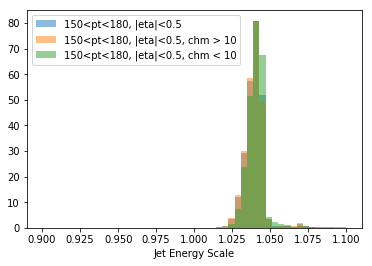

In [18]:
plt.figure()
bins = np.linspace(0.9, 1.1, 50)
plt.hist(df_all['jet_jes'][(df_all['jet_pt']>150) & 
                             (df_all['jet_pt']<180) & 
                             (df_all['jet_eta']>-0.5) & 
                             (df_all['jet_eta']<0.5)], bins, label='150<pt<180, |eta|<0.5', alpha=0.5, normed=True)
plt.hist(df_all['jet_jes'][(df_all['jet_pt']>150) & 
                             (df_all['jet_pt']<180) & 
                             (df_all['jet_eta']>-0.5) & 
                             (df_all['jet_eta']<0.5) &
                             (df_all['chm'] > 10)], bins, label='150<pt<180, |eta|<0.5, chm > 10', alpha=0.5, normed=True)
plt.hist(df_all['jet_jes'][(df_all['jet_pt']>150) & 
                             (df_all['jet_pt']<180) & 
                             (df_all['jet_eta']>-0.5) & 
                             (df_all['jet_eta']<0.5) &
                             (df_all['chm'] < 10)], bins, label='150<pt<180, |eta|<0.5, chm < 10', alpha=0.5, normed=True)
plt.xlabel('Jet Energy Scale')
plt.legend(loc='upper left')
plt.show()

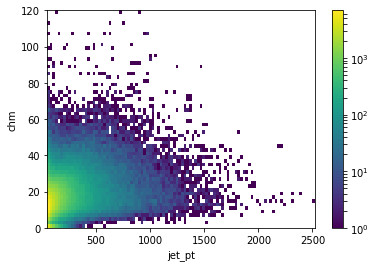

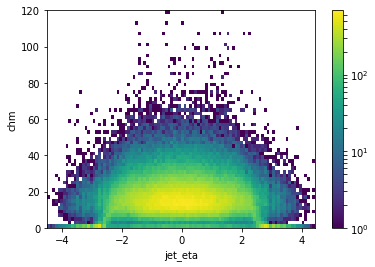

In [19]:
plt.figure()
plt.hist2d(df_all['jet_pt'], df_all['chm'], bins=(100, 60), norm=mpl.colors.LogNorm())
plt.colorbar()
plt.xlabel('jet_pt')
plt.ylabel('chm')
plt.show()
plt.figure()
plt.hist2d(df_all['jet_eta'], df_all['chm'], bins=(100, 60), norm=mpl.colors.LogNorm())
plt.colorbar()
plt.xlabel('jet_eta')
plt.ylabel('chm')
plt.show()

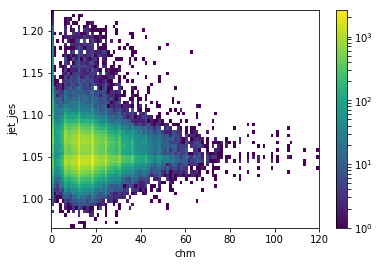

In [20]:
plt.figure()
plt.hist2d(df_all['chm'], df_all['jet_jes'], bins=(100, 60), norm=mpl.colors.LogNorm())
plt.colorbar()
plt.ylabel('jet_jes')
plt.xlabel('chm')
plt.show()

/usr/lib64/python2.7/dist-packages/matplotlib/axes/_axes.py:6201: RuntimeWarning: invalid value encountered in true_divide
  m = (m.astype(float) / db) / m.sum()


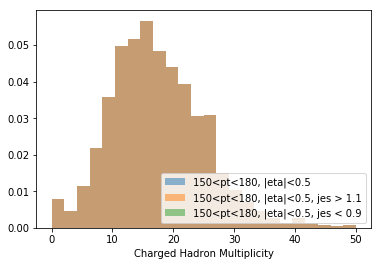

In [21]:
plt.figure()
bins = np.linspace(0, 50, 25)
plt.hist(df_all['chm'][(df_all['jet_pt']>150) & 
                             (df_all['jet_pt']<180) & 
                             (df_all['jet_eta']>-0.5) & 
                             (df_all['jet_eta']<0.5)], bins, label='150<pt<180, |eta|<0.5', alpha=0.5, normed=True)
plt.hist(df_all['chm'][(df_all['jet_pt']>150) & 
                             (df_all['jet_pt']<180) & 
                             (df_all['jet_eta']>-0.5) & 
                             (df_all['jet_eta']<0.5) &
                             (df_all['jet_jes'] > 1.0)], bins, label='150<pt<180, |eta|<0.5, jes > 1.1', alpha=0.5, normed=True)
plt.hist(df_all['chm'][(df_all['jet_pt']>150) & 
                             (df_all['jet_pt']<180) & 
                             (df_all['jet_eta']>-0.5) & 
                             (df_all['jet_eta']<0.5) &
                             (df_all['jet_jes'] < 1.0)], bins, label='150<pt<180, |eta|<0.5, jes < 0.9', alpha=0.5, normed=True)
plt.xlabel('Charged Hadron Multiplicity')
plt.legend(loc='lower right')
plt.show()

## Finish preprocessing

#### Normalize variables

In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_all['scaled_pt'] = scaler.fit_transform(np.log10(df_all['jet_pt']).values.reshape(-1,1))
df_all['jet_eta'] /= 5.0
df_all['jet_images'] = df_all['jet_images']/df_all['jet_images'].apply(np.max)

#### Check normalized variables

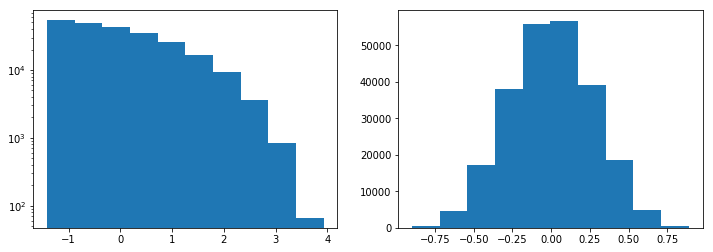

In [23]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.hist(df_all['scaled_pt'])
plt.yscale('log')
plt.subplot(1,2,2)
plt.hist(df_all['jet_eta'])
plt.show()

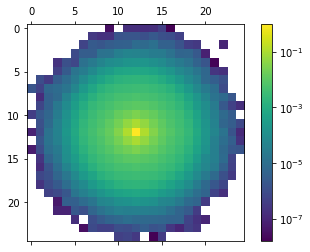

In [24]:
avg_image = np.sum(df_all.jet_images)/len(df_all)

fig, ax = plt.subplots()
cax = ax.matshow(avg_image.reshape((nx, ny)), norm=mpl.colors.LogNorm())
cbar = fig.colorbar(cax, ticks=[0.0000001, 0.00001, 0.001, 0.1, 1])

#### Split data into train/val/test sets and save files

In [ ]:
from sklearn.model_selection import train_test_split
df_all_train, df_all_val = train_test_split(df_all, train_size=0.8, random_state = seed)
# df_all_val, df_all_test = train_test_split(df_all_val, train_size=0.5, random_state=seed)

print('Training events = {}, Validation events = {}, Testing events = {}'.format(df_all_train.shape[0], df_all_val.shape[0], 0))

In [26]:
# Remove intermediary files due to disk space limitations
if True:
    for i in range(first_file, last_file+1):
        if i==8: continue; ## Missing file 8
        os.system('rm data/{}/df_jets_{}_{}.pkl'.format(radius, radius, i))

In [27]:
# Save combined dfs to disk
df_all_train.to_pickle('data/{}/df_jets_{}_train.pkl'.format(radius, radius))
df_all_val.to_pickle('data/{}/df_jets_{}_val.pkl'.format(radius, radius))